## SFC Meteorology Obs from:
** - 2021 M2 (BSPR-2A) **   
*** - 2021 M2 (BSM-2A) ***

__pyversion__==3.8   
__author__==S.Bell

In [41]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2021-07-13 13:55:48.091363


### connecting to erddap and retrieving and basic information

In [42]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url = 'http://redwing.pmel.noaa.gov:8081/erddap'

e = ERDDAP(server=server_url)

In [43]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='M200'))

In [44]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 5 tabledap, 0 griddap, and 0 wms endpoints.'

In [45]:
datasets = df['Dataset ID'].values
print(datasets)

['TELOM200_ATRH' 'TELOM200_BARO' 'TELOM200_PRAWC_M200'
 'TELOM200_PRAWE_M200' 'TELOM200_WIND']


In [46]:
variables = [e.get_var_by_attr(dataset_id=dataset, standard_name=lambda v: v is not None) for dataset in datasets]
print(variables)

[['RH', 'time', 'longitude', 'latitude', 'Air_Temp'], ['time', 'longitude', 'latitude', 'BaroPres'], ['Epoch_Time', 'time', 'weblab_Chlorophyll', 'longitude', 'SB_Depth', 'Optode_Dissov_O2', 'SB_Conductivity', 'SB_Temp', 'weblab_FDOM', 'latitude', 'Optode_Temp'], ['longitude', 'time', 'Depth', 'latitude'], ['time', 'longitude', 'latitude']]


### getting Peggy Buoy (BSM-2A) Data

In [76]:
wdf = pd.read_csv('http://ecofoci-field.pmel.noaa.gov/bell/dynamic_data/ArgosMooring/data/TotalArgosMessage_28882.csv',
                  parse_dates=True,index_col='sampletime')

In [86]:
wdf.index = wdf.index.round('1H')
wdf

,year_doy_hhmm,argosid,latitude,longitude,BP,AT,BV,RH,WS,WD,SR,AZ
sampletime,,,,,,,,,,,,
2021-03-09 02:00:00,2021-03-09 02:42:00,28882,47.68600,122.25646,1011.764706,9.5,12.0,50.0,0.2,114.358323,98.825080,271.071580
2021-03-09 04:00:00,2021-03-09 04:27:00,28882,47.68477,122.25709,1012.941176,5.6,11.0,75.0,0.4,158.125088,60.393104,271.071580
2021-03-10 03:00:00,2021-03-10 03:38:00,28882,47.68416,122.25755,1012.941176,5.7,11.0,86.0,0.3,352.957786,21.961129,271.071580
2021-03-11 02:00:00,2021-03-11 02:15:00,28882,47.68263,122.25757,1015.294118,7.8,11.0,71.0,1.1,313.426514,664.324146,271.071580
2021-03-11 02:00:00,2021-03-11 02:17:00,28882,47.68263,122.25757,1015.294118,7.8,11.0,71.0,1.1,313.426514,664.324146,271.071580
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-18 18:00:00,2021-05-18 20:51:00,28882,56.87629,164.07143,1018.823529,3.2,9.0,88.0,6.3,42.354934,400.790601,271.071580
2021-05-18 18:00:00,2021-05-18 20:52:00,28882,56.87629,164.07143,1018.823529,6.4,1.0,88.0,NaN,14.118311,422.751729,321.897501
2021-05-23 18:00:00,2021-05-23 20:48:00,28882,56.87467,164.06731,NaN,NaN,NaN,NaN,NaN,317.662008,1010.211925,77.650713


In [87]:
start_date=datetime.date(2021,5,6)
end_date=datetime.datetime.now()

### retrieving erddap and plotting data

In [88]:
dfs = {}
for dataset in ['TELOM200_ATRH','TELOM200_BARO','TELOM200_WIND']:
    d = ERDDAP(server=server_url,
               protocol='tabledap',
               response='csv',
              )

    d.dataset_id=dataset


#     d.relative_constraints = {'time>': 'now-3months'}

    df = d.to_pandas(
        index_col='time (UTC)',
        parse_dates=True,
        skiprows=(1,)  # units information can be dropped.
    ).dropna()

    df.sort_index(inplace=True)
    df.columns = [x[1].split()[0] for x in enumerate(df.columns)]

    df = df.sort_index()

    dfs.update({dataset:df})

In [51]:
df=pd.concat([dfs['TELOM200_ATRH'],dfs['TELOM200_BARO'],dfs['TELOM200_WIND']],axis=1)
df.columns

Index(['latitude', 'longitude', 'timeseries_id', 'RH', 'Air_Temp', 'latitude',
       'longitude', 'timeseries_id', 'BaroPres', 'latitude', 'longitude',
       'timeseries_id', 'U_wind', 'Uwind_Std', 'V_wind', 'Vwind_Std'],
      dtype='object')

### Take care of any preliminary QC

In [52]:
#calculate windspeed and direction
df['wind_speed (m s-1)']=np.sqrt(df['V_wind']**2 + df['U_wind']**2)
df['wind_from_direction (degrees true)'] = 270-np.rad2deg(np.arctan2(df['V_wind'],
                                                                 df['U_wind']))

df['wind_from_direction (degrees true)'][df['wind_from_direction (degrees true)']>360] = df['wind_from_direction (degrees true)'][df['wind_from_direction (degrees true)']>360]-360


/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


### Plot

In [53]:
import matplotlib as mpl
import matplotlib.pyplot as plt

### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean

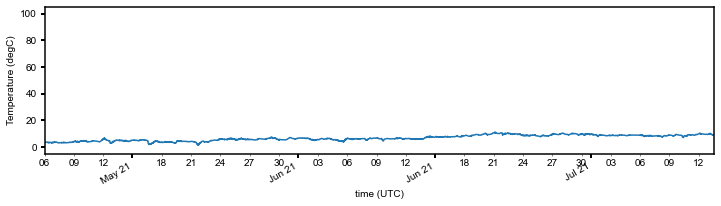

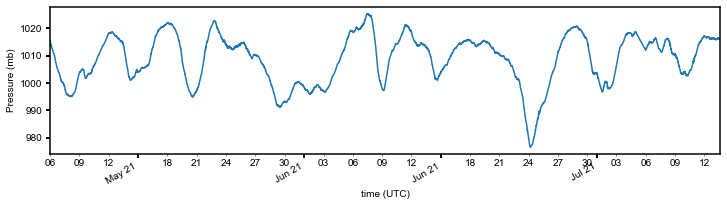

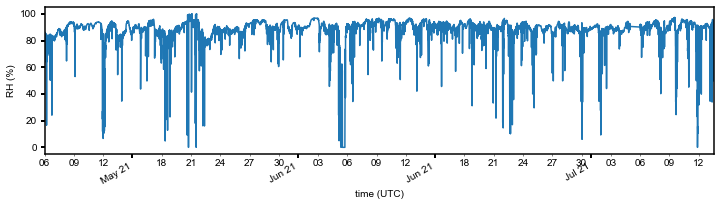

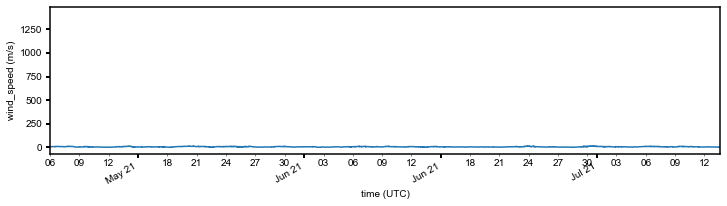

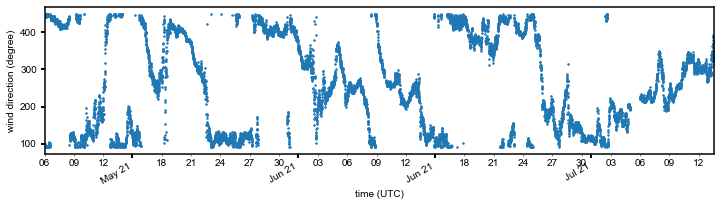

In [55]:
fig, ax = plt.subplots(figsize=(12,3))
try:
    df['Air_Temp'].plot(ax=ax)
    plt.ylabel('Temperature (degC)')
except:
    pass
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(DayLocator(bymonthday=[1,15]))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))

fig, ax = plt.subplots(figsize=(12,3))
try:
    df['BaroPres'].plot(ax=ax)
    plt.ylabel('Pressure (mb)')
except:
    df['BaroPres (mbar)'].plot(ax=ax)
    plt.ylabel('Pressure (mb)')
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(DayLocator(bymonthday=[1,15]))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))

fig, ax = plt.subplots(figsize=(12,3))
try:
    df['RH'].plot(ax=ax)
    plt.ylabel('RH (%)')
except:
    pass

ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(DayLocator(bymonthday=[1,15]))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))
    
fig, ax = plt.subplots(figsize=(12,3))
try:
    df['wind_speed (m s-1)'].plot(ax=ax)
    plt.ylabel('wind_speed (m/s)')
except:
    pass

ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(DayLocator(bymonthday=[1,15]))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))

fig, ax = plt.subplots(figsize=(12,3))
try:
    df['wind_from_direction (degrees true)'].plot(style='.',markersize=3.0,ax=ax)
    plt.ylabel('wind direction (degree)')
except:
    pass
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(DayLocator(bymonthday=[1,15]))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))

### Next Steps

**TODO:** Plot top prawler bin/air temp for a SST/Air analysis

In [60]:
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

d.dataset_id='TELOM200_PRAWC_M200'

"""
d.variables =  [
 'SB_Depth',
 'SB_Temp',
 'SB_Conductivity',
 'Optode_Temp',
 'Optode_Dissolved_O2',
 'wetlab_Chlorophyll',
 'wetlab_FDOM',
 "time"
]
"""

"""
d.constraints = {
    'time>=': '2021-02-01T00:00:00Z',
    'time<=': '2021-08-01T00:00:00Z',
}
"""

d.relative_constraints = {'time>': 'now-3months'}

df_sst = d.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df_sst.sort_index(inplace=True)
df_sst.columns = [x[1].split()[0] for x in enumerate(df_sst.columns)]

df_sst.sort_index(inplace=True)

df_sst.head()

,latitude,longitude,profile_id,Epoch_Time,SB_Depth,SB_Temp,SB_Conductivity,Optode_Temp,Optode_Dissov_O2,weblab_Chlorophyll,weblab_FDOM
time (UTC),,,,,,,,,,,
2021-05-05 05:36:22+00:00,57.84,-164.04,PROFILE_60922ED6,60922ED6,4.27,2.531,2.905,2.691,391.25,134.0,146.0
2021-05-05 05:36:30+00:00,57.84,-164.04,PROFILE_60922ED6,60922EDE,3.88,2.585,2.907,2.688,391.21,119.0,128.0
2021-05-05 05:36:38+00:00,57.84,-164.04,PROFILE_60922ED6,60922EE6,3.91,2.656,2.907,2.682,391.30,123.0,135.0
2021-05-05 05:36:46+00:00,57.84,-164.04,PROFILE_60922ED6,60922EEE,4.64,2.656,2.907,2.682,391.26,132.0,141.0
2021-05-05 05:36:54+00:00,57.84,-164.04,PROFILE_60922ED6,60922EF6,5.15,2.656,2.907,2.687,391.11,138.0,133.0


In [73]:
dfint= df_sst.groupby('profile_id')
sst,sst_time = [], []
for i,cast in enumerate(sorted(dfint.groups)):
    if (dfint.get_group(cast)['SB_Depth'].std() > 5) and (dfint.get_group(cast)['SB_Depth'].min() < 5):
        sst_time = sst_time + [dfint.get_group(cast).index[0]]
        #print(dfint.get_group(cast)['Temperature'][0:10])
        sst = sst +[(dfint.get_group(cast)['SB_Temp'][0:5]).median()]

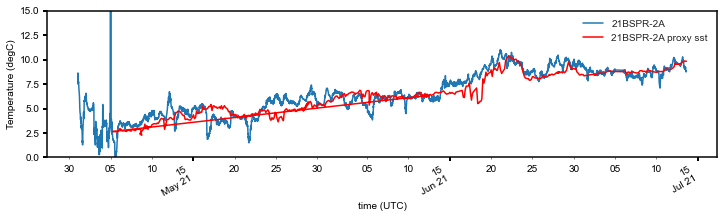

In [74]:
fig, ax = plt.subplots(figsize=(12,3))
df['Air_Temp'].plot()
plt.ylabel('Temperature (degC)')
plt.plot(sst_time,sst,'r')
plt.legend(['21BSPR-2A','21BSPR-2A proxy sst'])
ax.set_ylim([0,15])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,5)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)